<a href="https://colab.research.google.com/github/Rosefinch-Midsummer/Awesome-Colab/blob/master/NLP/%E2%80%9CBasic_Embedding_Model_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NNLM-Torch

[Paper - A Neural Probabilistic Language Model(2003)](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [1]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

dtype = torch.FloatTensor

sentences = [ "i like dog", "i love coffee", "i hate milk"]

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict) # number of Vocabulary

# NNLM Parameter
n_step = 2 # n-1 in paper
n_hidden = 2 # h in paper
m = 2 # m in paper

def make_batch(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]]
        target = word_dict[word[-1]]

        input_batch.append(input)
        target_batch.append(target)

    return input_batch, target_batch

# Model
class NNLM(nn.Module):
    def __init__(self):
        super(NNLM, self).__init__()
        self.C = nn.Embedding(n_class, m)
        self.H = nn.Parameter(torch.randn(n_step * m, n_hidden).type(dtype))
        self.W = nn.Parameter(torch.randn(n_step * m, n_class).type(dtype))
        self.d = nn.Parameter(torch.randn(n_hidden).type(dtype))
        self.U = nn.Parameter(torch.randn(n_hidden, n_class).type(dtype))
        self.b = nn.Parameter(torch.randn(n_class).type(dtype))

    def forward(self, X):
        X = self.C(X)
        X = X.view(-1, n_step * m) # [batch_size, n_step * n_class]
        tanh = torch.tanh(self.d + torch.mm(X, self.H)) # [batch_size, n_hidden]
        output = self.b + torch.mm(X, self.W) + torch.mm(tanh, self.U) # [batch_size, n_class]
        return output

model = NNLM()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

input_batch, target_batch = make_batch(sentences)
input_batch = Variable(torch.LongTensor(input_batch))
target_batch = Variable(torch.LongTensor(target_batch))

# Training
for epoch in range(5000):

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, n_class], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1)%1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Predict
predict = model(input_batch).data.max(1, keepdim=True)[1]

# Test
print([sen.split()[:2] for sen in sentences], '->', [number_dict[n.item()] for n in predict.squeeze()])


Epoch: 1000 cost = 0.034510
Epoch: 2000 cost = 0.007976
Epoch: 3000 cost = 0.003219
Epoch: 4000 cost = 0.001559
Epoch: 5000 cost = 0.000822
[['i', 'like'], ['i', 'love'], ['i', 'hate']] -> ['dog', 'coffee', 'milk']


## Word2Vec-Torch(Softmax)

[Paper - Distributed Representations of Words and Phrases and their Compositionality(2013)](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

Epoch: 1000 cost = 2.413484
Epoch: 2000 cost = 2.194266
Epoch: 3000 cost = 2.071284
Epoch: 4000 cost = 1.790286
Epoch: 5000 cost = 1.910651


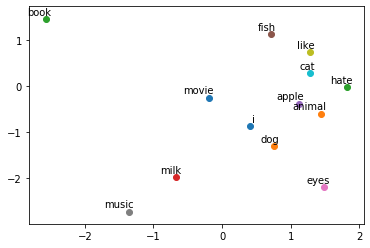

In [2]:
'''
  code by Tae Hwan Jung(Jeff Jung) @graykode
'''
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

# 3 Words Sentence
sentences = [ "i like dog", "i like cat", "i like animal",
              "dog cat animal", "apple cat dog like", "dog fish milk like",
              "dog cat eyes like", "i like apple", "apple i hate",
              "apple i movie book music like", "cat dog hate", "cat dog like"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}

# Word2Vec Parameter
batch_size = 20  # To show 2 dim embedding graph
embedding_size = 2  # To show 2 dim embedding graph
voc_size = len(word_list)

def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # target
        random_labels.append(data[i][1])  # context word

    return random_inputs, random_labels

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([target, w])

# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()

        # W and WT is not Traspose relationship
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1).type(dtype) # voc_size > embedding_size Weight
        self.WT = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1).type(dtype) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = torch.matmul(X, self.W) # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.WT) # output_layer : [batch_size, voc_size]
        return output_layer

model = Word2Vec()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(5000):

    input_batch, target_batch = random_batch(skip_grams, batch_size)

    input_batch = Variable(torch.Tensor(input_batch))
    target_batch = Variable(torch.LongTensor(target_batch))

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1)%1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

for i, label in enumerate(word_list):
    W, WT = model.parameters()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()


## FastText

[Paper - Bag of Tricks for Efficient Text Classification(2016)](https://arxiv.org/pdf/1607.01759.pdf)

In [3]:
!wget https://github.com/facebookresearch/fastText/archive/0.2.0.zip
!unzip 0.2.0.zip
%cd fastText-0.2.0
!make

--2019-12-19 01:41:01--  https://github.com/facebookresearch/fastText/archive/0.2.0.zip
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/0.2.0 [following]
--2019-12-19 01:41:02--  https://codeload.github.com/facebookresearch/fastText/zip/0.2.0
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘0.2.0.zip’

0.2.0.zip               [   <=>              ]   4.10M  7.98MB/s    in 0.5s    

2019-12-19 01:41:03 (7.98 MB/s) - ‘0.2.0.zip’ saved [4304799]

Archive:  0.2.0.zip
7842495a4d64c7a3bb4339d45d6e64321d002ed8
   creating: fastText-0.2.0/
   creating: fastText-0.2.0/.circleci/
  inflating: fastText-0.2

In [0]:
# 1 is positive, 0 is negative
f = open('train.txt', 'w')
f.write('__label__1 i love you\n')
f.write('__label__1 he loves me\n')
f.write('__label__1 she likes baseball\n')
f.write('__label__0 i hate you\n')
f.write('__label__0 sorry for that\n')
f.write('__label__0 this is awful')
f.close()

f = open('test.txt', 'w')
f.write('sorry hate you')
f.close()

In [5]:
!./fasttext supervised -input train.txt -output model -dim 2

Read 0M words
Number of words:  17
Number of labels: 2
Progress: 100.0% words/sec/thread:     168 lr:  0.000000 loss:  0.672308 ETA:   0h 0m


In [6]:
!cat test.txt
!./fasttext predict model.bin test.txt

sorry hate you__label__0
